# Spectroscopy of a three cavity - two qubit system, with thermal losses: <mark>Solving the Master Equation</mark>

1. **Introduction**
2. **Problem parameters**
3. **Setting up operators and Hamiltonian's**
4. **Frequency spectrum of the coupled system**
5. **Evolving qubit 1 in the system with time**

<u>Author</u> : Soumya Shreeram (shreeramsoumya@gmail.com)<br>
<u>Supervisor</u> : Yu-Chin Chao (ychao@fnal.gov) <br>
<u>Date</u>$\ \ \ \$: 7th July 2019<br>

This script was coded as part of the Helen Edwards Summer Internship program at Fermilab.

## 1. Introduction

A multi-mode QED architecture is explored as described in by [McKay et *al*](http://schusterlab.uchicago.edu/static/pdfs/McKay2015.pdf). The hamiltonian for such a system with two qubits with frequencies $v_{Q,1}$, $v_{Q,2}$, and $n$ mode filter can be described as the sum of the qubit Hamiltonian, $\hat{H}_Q$, the filter Hamiltonian, $\hat{H}_F$, and the qubit-filter coupling Hamiltonian, $\hat{H}_{Q-F},$
$$ \hat{H} = \hat{H_Q} + \hat{H_F} + \hat{H}_{Q-F} $$

$$ \hat{H_Q} = h\ v_{Q,1}\ \frac{\hat{ \sigma}^z_1}{2} + h\ v_{Q,2}\ \frac{\hat{ \sigma}^z_2}{2}$$

$$ \hat{H}_{F} = \sum_{i=1}^{n}h\ v_{F}\ \hat{a}^{\dagger}_i \hat{a}_i +  \sum_{i=2}^{n}h\ g_{F}\ (\hat{a}^{\dagger}_i \hat{a}_{i-1} + \hat{a}^{\dagger}_{i-1} \hat{a}_i)$$

$$ \hat{H}_{Q-F} = h\ g_{Q1,F}\ (\hat{a}^{\dagger}_1 \hat{\sigma}^-_1 + \hat{a}_1 \hat{\sigma}^+_1) + h\ g_{Q2,F}\ (\hat{a}^{\dagger}_n \hat{\sigma}^-_2 + \hat{a}_n \hat{\sigma}^+_2)$$

where $\hat{\sigma}^{+(-)}$ is the raising and lowering operator for the qubit, $\hat{a}_i$ creates a photon in the $i^{th}$ resonantor, $g_F$ is the filter-filter coupling, and $g_{Q,F}$ is the qubit-filter coupling.

Here we must also account for the interaction of the quantum state with it's environment. This can be represented by a non-Hermitian term in the Hamiltonian such that,
$$\displaystyle H_{\rm eff}(t) = H(t) - \frac{i\hbar}{2}\sum_n c_n^\dagger c_n$$
where $c_n$ is the collapse operator

The code calculates the eigen modes for such a system when the qubit 1 frequency is changed. 

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
import numpy as np
from math import pi
from qutip import *

## 2. Problem parameters
Here we use $\hbar=1$; the coupling terms are redefined with a multiple of $2\pi$ before them for convinience.

In [20]:
"""------------- FREQUENCIES --------------------"""
w_q1 = 2*pi*6.5;    # Qubit 1 frequency
w_q2 = 2*pi*6.8;    # Qubit 2 frequency: range from 1-9 GHz
w_f = 2*pi*7.1      # Resonator/ Filter frequency
"""------------- COUPLING --------------------"""
g_f1 = 2*pi*1.18    # Filter-filter coupling
g_f2 = 2*pi*3.44 
g_q1f = 2*pi*1.35   # qubit 1-fitler coupling
g_q2f = 2*pi*4.15   # qubit 2-fitler coupling

numF = 3            # number of filters
N = 2               # number of fock states 

kappa = 1.0/0.129   # cavity dissipation rate
n_th_a = 0.063      # avg. no. of thermal bath excitation
r1 = 0.0075           # qubit relaxation rate
r2 = 0.0025           # qubit dephasing rate

## 3. Setting up operators and the Hamiltonian's

For every qubit: <br> <br>
**sm** $\ \rightarrow \ \hat{\sigma}^{+(-)}$ is the raising and lowering operator of the *qubit* <br>
**sz** $\ \ \rightarrow \ \sigma_z $ is the Pauli-z matrix of the *qubit* <br>
**n** $\ \ \ \rightarrow \ n$ is the number operator

In [21]:
def numOp(m):
  """
  Computes the number operator 
  @param loweringMat :: lowering matrix operator for a system
  """
  return m.dag()*m

def rwaCoupling(m1, m2):
    return m1.dag()*m2 + m1*m2.dag()

### 3.1 Qubit-cavity system operators and Hamiltonian's

In [22]:
# cavity 1, 2, 3 destruction operators
a1 = tensor(destroy(N), qeye(N), qeye(N), qeye(2), qeye(2))
a2 = tensor(qeye(N), destroy(N), qeye(N), qeye(2), qeye(2))
a3 = tensor(qeye(N), qeye(N), destroy(N), qeye(2), qeye(2))

# operators for qubit 1 
sm1 = tensor(qeye(N), qeye(N), qeye(N), sigmam(), qeye(2))
sz1 = tensor(qeye(N), qeye(N), qeye(N), sigmaz(), qeye(2))    
n1 = sm1.dag() * sm1

# operators for qubit 2
sm2 = tensor(qeye(N), qeye(N), qeye(N), qeye(2), sigmam())
sz2 = tensor(qeye(N), qeye(N), qeye(N), qeye(2), sigmaz())
n2 = sm2.dag() * sm2

# collapse operators
c_ops = []

In [23]:
# Qubit Hamiltonians (Hq1+Hq2)
Hq1 = 0.5*sz1       
Hq2 = 0.5*sz2

# Filter Hamiltonians (refer formula in the Introduction)
Hf = numOp(a1) + numOp(a2) + numOp(a3)    
H_f12 = g_f1*(rwaCoupling(a1, a2) + rwaCoupling(a2, a3))

# Qubit-Filter Hamiltonian
Hqf = g_q1f*(rwaCoupling(a1, sm1) + rwaCoupling(a3, sm2))

# Qubit 1 -independent Hamiltonian (see later)
H0 = H_f12 + Hqf + w_f*Hf + w_q2*Hq2
 
H = w_f*Hf + H_f12 + Hqf + w_q1*Hq1 + w_q2*Hq2  # Resultant Hamiltonian

### 3.2 Collapse operator used to describe dissipation

In [24]:
# collapse operator list
c_ops = []

# cavity relaxation
rate = kappa * (1 + n_th_a)
c_ops.append(np.sqrt(rate) * a1)
    
# cavity excitation

# qubit 1 relaxation
c_ops.append(np.sqrt(r1 * (1+n_th_a)) * sm1)
c_ops.append(np.sqrt(r1 * n_th_a) * sm1.dag())
c_ops.append(np.sqrt(r2) * sz1)

# qubit 2 relaxation
c_ops.append(np.sqrt(r1 * (1+n_th_a)) * sm2)
c_ops.append(np.sqrt(r1 * n_th_a) * sm2.dag())
c_ops.append(np.sqrt(r2) * sz2)

In [28]:
# initial state of the system. Qubit 1: excited, Qubit 2: ground st.
psi0 = tensor(basis(N,0), basis(N,0), basis(N,0), basis(2,0), basis(2,1))

times = np.linspace(0.0,6,500)
output = mesolve(H, psi0, times, c_ops, [n1, n2, numOp(a1), numOp(a2), numOp(a3)])

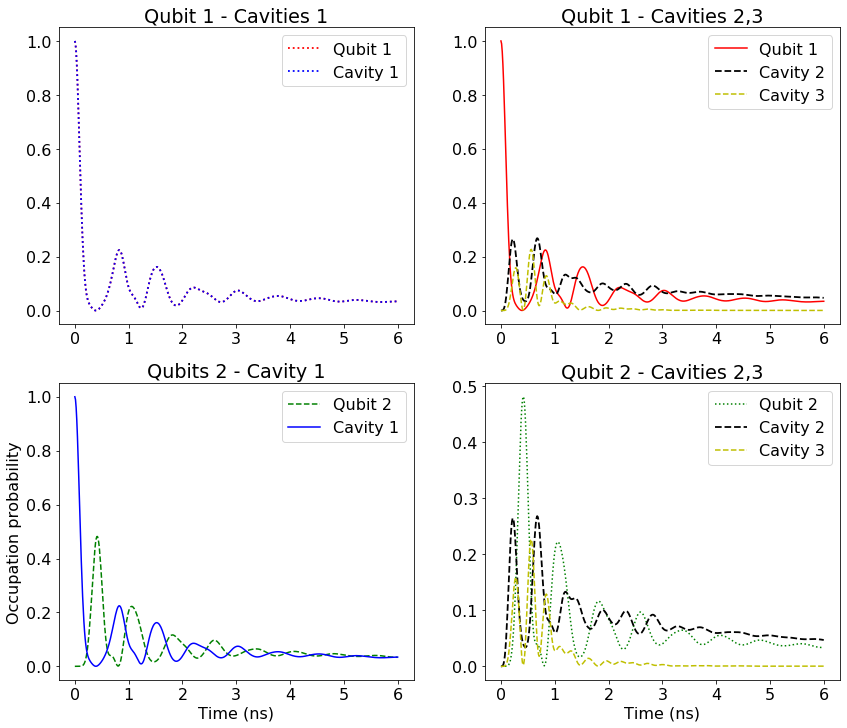

In [29]:
fig, ax = plt.subplots(2, 2, figsize=(14,12))
# qubit 1 - Cavity 1
ax[0, 0].plot(times, output.expect[0], 'r:', linewidth=1.8, label="Qubit 1")
ax[0, 0].plot(times, output.expect[0], 'b:', linewidth=1.8, label="Cavity 1")
ax[0, 0].set_title('Qubit 1 - Cavities 1');
ax[0, 0].legend(loc="upper right")

# qubit 1 - Cavity 2, 3
ax[0, 1].plot(times, output.expect[0], 'r-', label="Qubit 1")
ax[0, 1].plot(times, output.expect[3], 'k--', linewidth=1.8, label="Cavity 2")
ax[0, 1].plot(times, output.expect[4], 'y--', linewidth=1.5, label="Cavity 3")
ax[0, 1].set_title('Qubit 1 - Cavities 2,3');
ax[0, 1].legend(loc="upper right")

# qubit 2 - Cavity 1
ax[1, 0].plot(times, output.expect[1], 'g--', label="Qubit 2")
ax[1, 0].plot(times, output.expect[0], 'b', label="Cavity 1")
ax[1, 0].set_xlabel('Time (ns)');
ax[1, 0].set_ylabel('Occupation probability');
ax[1, 0].set_title('Qubits 2 - Cavity 1');
ax[1, 0].legend(loc="upper right")

# qubit 2 - Cavity 2, 3
ax[1,1].plot(times, output.expect[1], 'g:', linewidth=1.5, label="Qubit 2")
ax[1,1].plot(times, output.expect[3], 'k--', linewidth=1.8, label="Cavity 2")
ax[1, 1].plot(times, output.expect[4], 'y--', linewidth=1.5, label="Cavity 3")
ax[1,1].set_xlabel('Time (ns)')
ax[1,1].set_title('Qubit 2 - Cavities 2,3');
ax[1,1].legend(loc="upper right")

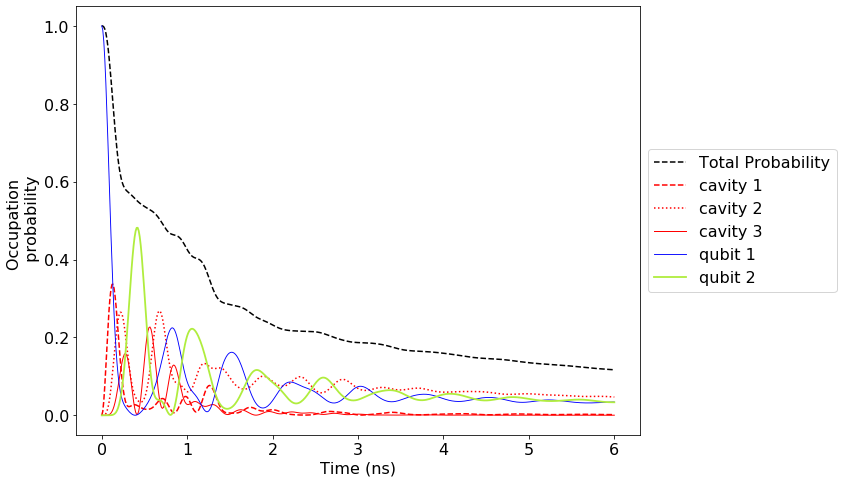

In [30]:
fig, axes = plt.subplots(1, 1, figsize=(12,7))

axes.plot(times, output.expect[0] + output.expect[1] + output.expect[2] + output.expect[3] + output.expect[4], 'k--', linewidth=1.5, label="Total Probability")
axes.plot(times, output.expect[2], 'r--', linewidth=1.5, label="cavity 1")
axes.plot(times, output.expect[3], 'r:', linewidth=1.5, label="cavity 2")
axes.plot(times, output.expect[4], 'r', linewidth=1, label="cavity 3")
axes.plot(times, output.expect[0], 'b', linewidth=0.9, label="qubit 1")
axes.plot(times, output.expect[1], '#b0ed3e', linewidth=1.8, label="qubit 2")
axes.set_xlabel("Time (ns)")
axes.set_ylabel("Occupation \n probability")
axes.legend(loc = 'center left', bbox_to_anchor = (1.0, 0.5))

fig.tight_layout()